In [1]:
using DrWatson
@quickactivate("Hierarchical_Infer_Spikes")

using HiddenMarkovModels, CSV, StatsPlots, DataFrames, Distributions, Random, LinearAlgebra

# this data was checked graphically to see that the spike counts in the delay zone match
# their assigned positions and that the outcome of the trial comes AFTER these spikes occur
data = CSV.File(datadir("exp_raw","Control_B1_performance.csv"),header=1)|> DataFrame
data[!,"animal"] = [findfirst(isequal(d),[2476,2495,2506,2507,2514,2520]) for d in data.animal]
data[!,"day"] = [findfirst(isequal(d),["D1","D2","D3","D4","D5"]) for d in data.day]
data = data[:,1:3] |> Matrix;
Random.seed!(1234)

TaskLocalRNG()

In [2]:
N_states = 3
init = ones(N_states)/N_states
trans = (I(N_states) .+ 0.5*ones(N_states))
trans = trans./sum(trans,dims=2)

dists = [Bernoulli(p) for p in LinRange(0.1, 0.9, N_states)]
hmm = HMM(init, trans, dists)

days = unique(data[:,2])
animals = unique(data[:,1])
seq_ends = findlast.([(data[:,2].==d .&& data[:,1] .== a for d in days for a in animals)...])
seq_ends = Int.(sort(seq_ends[seq_ends.!=nothing]))

est_hmm,ll = baum_welch(hmm, data[:,3];seq_ends)
guess,ll_fb = forward_backward(est_hmm, data[:,3];seq_ends)
guess_vit,ll_vit = viterbi(est_hmm, data[:,3];seq_ends)
obs_distributions(est_hmm)

3-element Vector{Bernoulli{Float64}}:
 Bernoulli{Float64}(p=0.05705742246305217)
 Bernoulli{Float64}(p=0.6545753809165562)
 Bernoulli{Float64}(p=0.9659649572944254)

## Reproduces Figure S3 for control animals

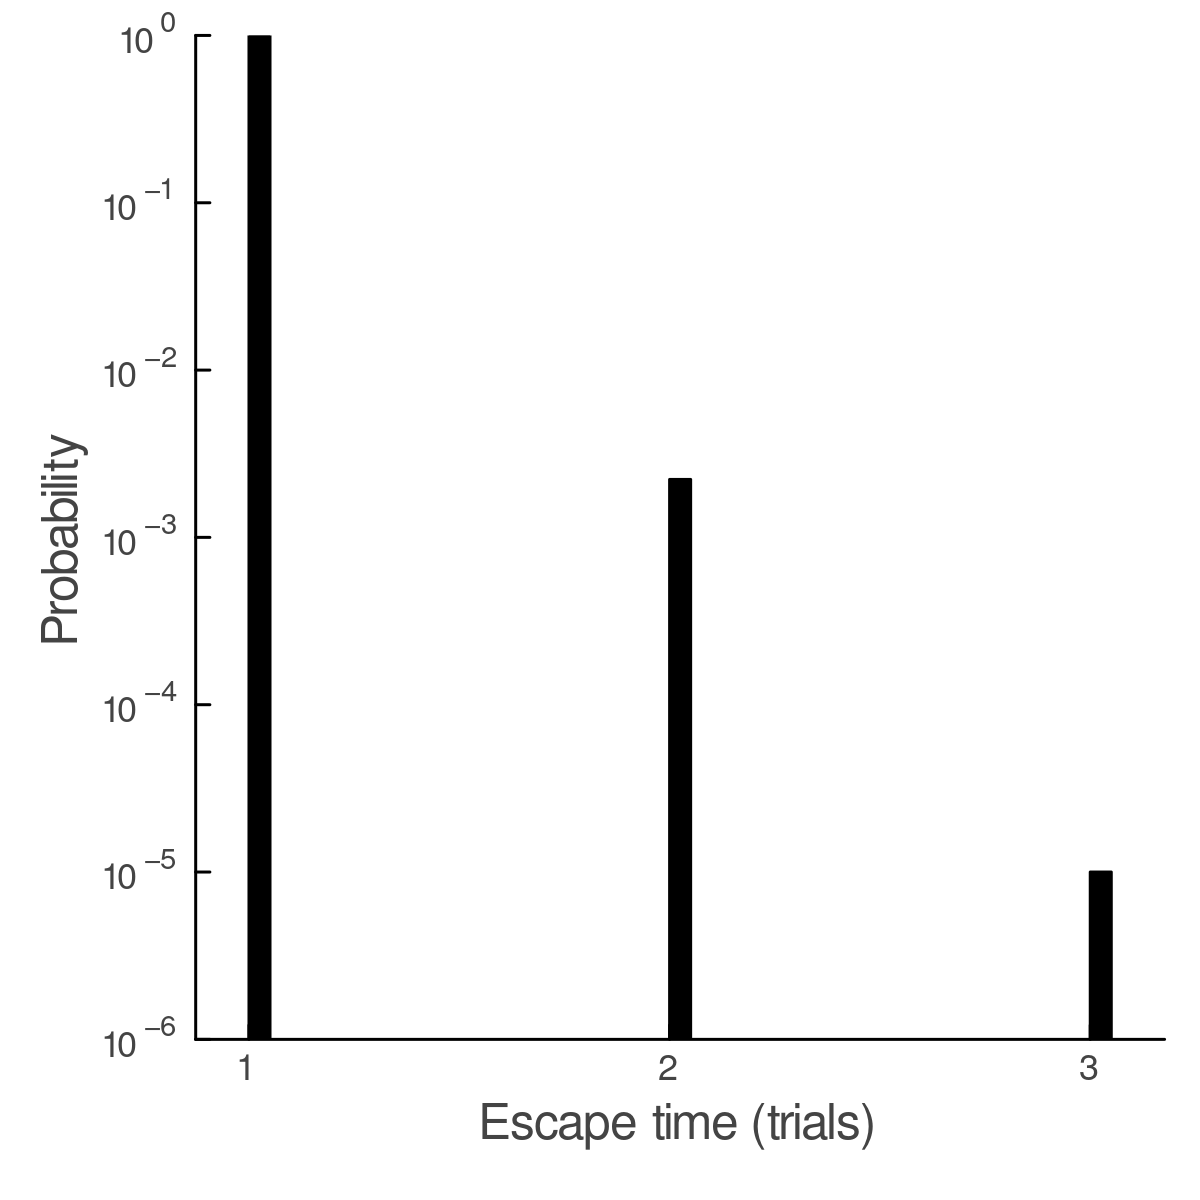

In [34]:
hmm_fixed = HMM([1,0,0],transition_matrix(est_hmm),obs_distributions(est_hmm))
N_sims = 100_000
first_escape_time = zeros(N_sims)
for i in 1:N_sims
    state_seq,_=rand(hmm_fixed, 200)
    first_escape_time[i] = findfirst(state_seq.!=1)-1
end

histogram(first_escape_time,normalize=:probability,grid=false,legend=false,fontfamily="Helvetica",color=:black,yscale=:log10)
xticks!(1:3)
ylims!(1e-6,1)
xlabel!("Escape time (trials)")
ylabel!("Probability")
plot!(size=(400,400),dpi=300)

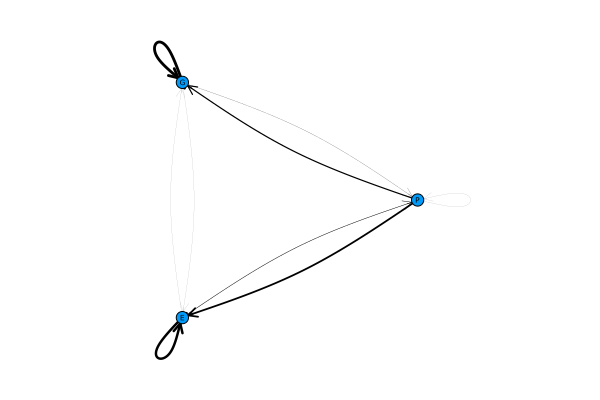

In [168]:
transition_matrix(est_hmm)

using Graphs, SimpleWeightedGraphs, GraphRecipes
# weighted digraph for each state, weighted by the transition probability
g = SimpleWeightedDiGraph(N_states)
for i in 1:N_states
    for j in 1:N_states
        add_edge!(g, i, j, transition_matrix(est_hmm)[i,j])
    end
end

# plot the graph
graphplot(g, names=["P","G","E"],edgewidth=3*transition_matrix(est_hmm),nodeshape=:circle,method=:circular,fontsize=5,self_edge_size=0.2,axis_buffer=0.3)

In [5]:
AIC_hmm(N,ll) = 2*N+N^2-2*ll # init + ps + matrix = N + N^2
AIC_hmm(N_states,last(ll))

384.4583048415338

## Reproduces Figure S2

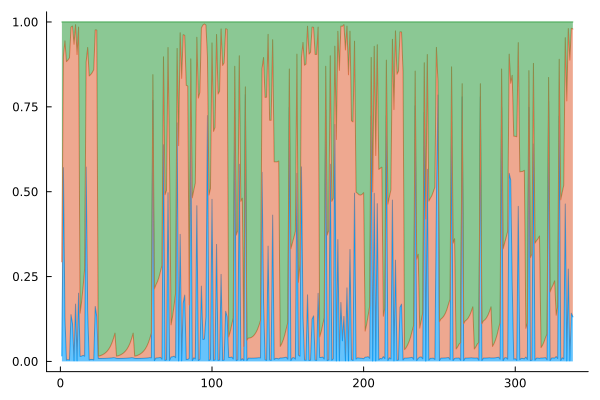

In [9]:
areaplot(1:length(guess[1,:]), guess',legend=false,fillalpha=0.6,grid=false)
#plot!(1:length(guess[1,:]), data[:,3],legend=false,grid=false,marker=:circle)
#xlims!(0,60)

In [8]:
# save plot to file
savefig(plotsdir("HMM_fit_ctrl.svg"))

"z:\\justidy1\\IctalSpikeDetect_for_Maryam_manuscript\\Statistical Tests\\Hierarchical_Infer_Spikes\\plots\\HMM_fit_ctrl.svg"